# Wearable ML Starter Project (End-to-End)
This notebook builds an **Activity Recognition** model using wearable IMU signals and deploys it as **TensorFlow Lite (INT8)**.

Pipeline:
1) Download dataset  
2) Load + preprocess  
3) Train a baseline (RandomForest)  
4) Train a deep model (1D CNN)  
5) Evaluate  
6) Convert to TFLite + quantize  
7) Run a streaming inference simulation

**Dataset:** UCI HAR (Human Activity Recognition Using Smartphones)

## 0) Setup

In [32]:
import os, zipfile, urllib.request, pathlib, numpy as np, pandas as pd
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True, parents=True)

# UCI HAR dataset URL
UCI_URL = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"
ZIP_PATH = DATA_DIR / "uci_har.zip"
EXTRACT_DIR = DATA_DIR / "UCI HAR Dataset"

print("Data dir:", DATA_DIR.resolve())


Data dir: /Users/muzamilshah/Documents/Learning/Wearable Devices/data


## 1) Download the dataset
If you already have the dataset extracted, this will skip download.

In [37]:
if not ZIP_PATH.exists():
    print("Downloading...")
    urllib.request.urlretrieve(UCI_URL, ZIP_PATH)
    print("Downloaded to:", ZIP_PATH)
if not EXTRACT_DIR.exists():
    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)
    print("Extracted to:", EXTRACT_DIR)
else:
    print("Dataset already present:", EXTRACT_DIR)


Dataset already present: data/UCI HAR Dataset


## 2) Load raw IMU signals (time-series) + labels
UCI HAR provides already-windowed signals (128 timesteps) for 9 channels:
- Body Acc (x,y,z)
- Body Gyro (x,y,z)
- Total Acc (x,y,z)

We'll build **1D CNN** on these raw windows.

It also provides engineered feature vectors; we'll use those for a RandomForest baseline.

In [38]:
import numpy as np

def load_inertial_signals(split: str):
    base = EXTRACT_DIR / split / "Inertial Signals"
    signal_files = [
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
    ]

    signals = []
    for s in signal_files:
        path = base / f"{s}{split}.txt"
        data = np.loadtxt(path)  # shape: (n_windows, 128)
        signals.append(data)

    # Stack into (n_windows, 128, 9)
    X = np.stack(signals, axis=-1)
    return X

def load_labels(split: str):
    y = np.loadtxt(EXTRACT_DIR / split / f"y_{split}.txt").astype(int)
    # labels are 1..6
    return y - 1

def load_subjects(split: str):
    sub = np.loadtxt(EXTRACT_DIR / split / f"subject_{split}.txt").astype(int)
    return sub

X_train_ts = load_inertial_signals("train")
y_train = load_labels("train")
sub_train = load_subjects("train")

X_test_ts = load_inertial_signals("test")
y_test = load_labels("test")
sub_test = load_subjects("test")

print("Train time-series:", X_train_ts.shape, "y:", y_train.shape, "subjects:", sub_train.shape)
print("Test  time-series:", X_test_ts.shape, "y:", y_test.shape, "subjects:", sub_test.shape)


Train time-series: (7352, 128, 9) y: (7352,) subjects: (7352,)
Test  time-series: (2947, 128, 9) y: (2947,) subjects: (2947,)


## 3) Label mapping

In [39]:
LABELS = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING",
}

from collections import Counter
print("Train class counts:", Counter(y_train))
print("Test  class counts:", Counter(y_test))


Train class counts: Counter({np.int64(5): 1407, np.int64(4): 1374, np.int64(3): 1286, np.int64(0): 1226, np.int64(1): 1073, np.int64(2): 986})
Test  class counts: Counter({np.int64(5): 537, np.int64(4): 532, np.int64(0): 496, np.int64(3): 491, np.int64(1): 471, np.int64(2): 420})


## 4) Baseline model (RandomForest) on engineered features
This baseline is fast and strong; it’s common in production wearables when compute is tight.

                    precision    recall  f1-score   support

           WALKING       0.90      0.97      0.93       496
  WALKING_UPSTAIRS       0.89      0.92      0.90       471
WALKING_DOWNSTAIRS       0.96      0.85      0.90       420
           SITTING       0.93      0.90      0.92       491
          STANDING       0.91      0.94      0.93       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



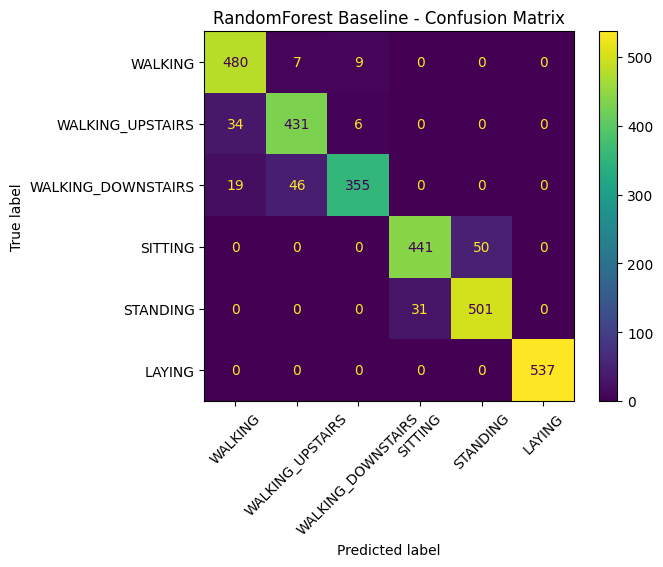

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_train_feat = np.loadtxt(EXTRACT_DIR / "train" / "X_train.txt")
X_test_feat  = np.loadtxt(EXTRACT_DIR / "test"  / "X_test.txt")

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
rf.fit(X_train_feat, y_train)
y_pred_rf = rf.predict(X_test_feat)

print(classification_report(y_test, y_pred_rf, target_names=[LABELS[i] for i in range(6)]))

cm = confusion_matrix(y_test, y_pred_rf, labels=list(range(6)))
disp = ConfusionMatrixDisplay(cm, display_labels=[LABELS[i] for i in range(6)])
disp.plot(xticks_rotation=45)
plt.title("RandomForest Baseline - Confusion Matrix")
plt.show()


## 5) Deep learning model (1D CNN) on raw windows
We train a small CNN that is **edge-friendly** and later convert it to TFLite.


In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Normalize using train statistics (per-channel)
mean = X_train_ts.mean(axis=(0,1), keepdims=True)
std  = X_train_ts.std(axis=(0,1), keepdims=True) + 1e-6

X_train = (X_train_ts - mean) / std
X_test  = (X_test_ts  - mean) / std

num_classes = 6

def make_cnn(input_shape=(128, 9), num_classes=6):
    inp = keras.Input(shape=input_shape)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(inp)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(128, 5, padding="same", activation="relu")(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inp, out)

model = make_cnn()
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 64, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 32, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,086 (367.52 KB)

 Trainable params: 94,086 (367.52 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/30
46/46 - 2s - 45ms/step - accuracy: 0.7327 - loss: 0.7318 - val_accuracy: 0.9320 - val_loss: 0.2688 - learning_rate: 0.0010
Epoch 2/30
46/46 - 1s - 19ms/step - accuracy: 0.9478 - loss: 0.1407 - val_accuracy: 0.9415 - val_loss: 0.2095 - learning_rate: 0.0010
Epoch 3/30
46/46 - 1s - 21ms/step - accuracy: 0.9583 - loss: 0.1035 - val_accuracy: 0.9429 - val_loss: 0.2134 - learning_rate: 0.0010
Epoch 4/30
46/46 - 1s - 19ms/step - accuracy: 0.9582 - loss: 0.0998 - val_accuracy: 0.9375 - val_loss: 0.2226 - learning_rate: 0.0010
Epoch 5/30
46/46 - 1s - 20ms/step - accuracy: 0.9606 - loss: 0.0923 - val_accuracy: 0.9415 - val_loss: 0.2369 - learning_rate: 0.0010
Epoch 6/30
46/46 - 1s - 20ms/step - accuracy: 0.9634 - loss: 0.0844 - val_accuracy: 0.9402 - val_loss: 0.2299 - learning_rate: 5.0000e-04
Epoch 7/30
46/46 - 1s - 20ms/step - accuracy: 0.9621 - loss: 0.0817 - val_accuracy: 0.9415 - val_loss: 0.2432 - learning_rate: 5.0000e-04
Epoch 8/30
46/46 - 1s - 20ms/step - accuracy: 0.9626 -

In [15]:
# Evaluate
y_prob = model.predict(X_test, verbose=0)
y_pred = y_prob.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=[LABELS[i] for i in range(6)]))


                    precision    recall  f1-score   support

           WALKING       0.96      0.99      0.98       496
  WALKING_UPSTAIRS       0.91      0.91      0.91       471
WALKING_DOWNSTAIRS       0.93      0.99      0.96       420
           SITTING       0.83      0.76      0.80       491
          STANDING       0.82      0.86      0.84       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



## 6) Convert to LiteRT (INT8 quantized)
Quantization makes the model smaller + faster for wearables.

We’ll use a small representative dataset from training windows.

In [43]:
import numpy as np

# Representative dataset for INT8 calibration
def rep_data_gen():
    # Use up to 1000 random windows
    idx = np.random.choice(len(X_train), size=min(1000, len(X_train)), replace=False)
    for i in idx:
        yield [X_train[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

TFLITE_PATH = Path("wearable_activity_cnn_int8.tflite")
TFLITE_PATH.write_bytes(tflite_model)

print("Saved:", TFLITE_PATH.resolve(), "Size (KB):", round(TFLITE_PATH.stat().st_size/1024, 2))


INFO:tensorflow:Assets written to: /var/folders/5j/qsjbxn8d0bg80rcj8xzcwf0h0000gn/T/tmp3lz02x2a/assets


INFO:tensorflow:Assets written to: /var/folders/5j/qsjbxn8d0bg80rcj8xzcwf0h0000gn/T/tmp3lz02x2a/assets


Saved artifact at '/var/folders/5j/qsjbxn8d0bg80rcj8xzcwf0h0000gn/T/tmp3lz02x2a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 9), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  13254031120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13254031312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13254032464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13254031696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13254032848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13254033232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13254031504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13254030928: TensorSpec(shape=(), dtype=tf.resource, name=None)


/Users/muzamilshah/miniforge3/envs/wearable/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1770667463.179578 10694090 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1770667463.179597 10694090 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2026-02-10 04:04:23.179731: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/5j/qsjbxn8d0bg80rcj8xzcwf0h0000gn/T/tmp3lz02x2a
2026-02-10 04:04:23.180124: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2026-02-10 04:04:23.180129: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/5j/qsjbxn8d0bg80rcj8xzcwf0h0000gn/T/tmp3lz02x2a
2026-02-10 04:04:23.184088: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2026-02-10 04:04:23.20407

Saved: /Users/muzamilshah/Documents/Learning/Wearable Devices/wearable_activity_cnn_int8.tflite Size (KB): 107.36


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
2026-02-10 04:04:24.697009: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3705] Skipping runtime version metadata in the model. This will be generated by the exporter.


## 7) Run TensorFlow LiteRT inference + streaming simulation
This simulates a wearable pipeline:
- buffer sensor data
- build a window
- run inference
- apply simple smoothing (majority vote over last N predictions)

In [44]:
import numpy as np
import collections
from ai_edge_litert.interpreter import Interpreter 
# interpreter = tf.lite.Interpreter(model_path=str(TFLITE_PATH))
interpreter = Interpreter(model_path=str(TFLITE_PATH))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

in_scale, in_zero = input_details[0]["quantization"]
out_scale, out_zero = output_details[0]["quantization"]

def tflite_predict(window_f32):
    # window_f32: (1, 128, 9) float32 normalized
    # quantize to int8
    x_q = np.round(window_f32 / in_scale + in_zero).astype(np.int8)
    interpreter.set_tensor(input_details[0]["index"], x_q)
    interpreter.invoke()
    y_q = interpreter.get_tensor(output_details[0]["index"])  # int8
    # dequantize
    y_f = (y_q.astype(np.float32) - out_zero) * out_scale
    return y_f

# Stream simulation using test set windows as if they arrive over time
smooth_N = 7
q = collections.deque(maxlen=smooth_N)

correct = 0
total = 200  # simulate first 200 windows
for i in range(total):
    window = X_test[i:i+1].astype(np.float32)
    y_true = int(y_test[i])

    y_f = tflite_predict(window)
    y_pred = int(np.argmax(y_f, axis=1)[0])

    q.append(y_pred)
    # majority vote
    y_smooth = max(set(q), key=list(q).count)

    correct += (y_smooth == y_true)

print(f"Streaming accuracy (majority vote N={smooth_N}) over {total} windows: {correct/total:.3f}")


Streaming accuracy (majority vote N=7) over 200 windows: 0.775
